In [ ]:
#Name: Haitao Peng
#Github Username: RuciHank
#USC ID: 6098846612

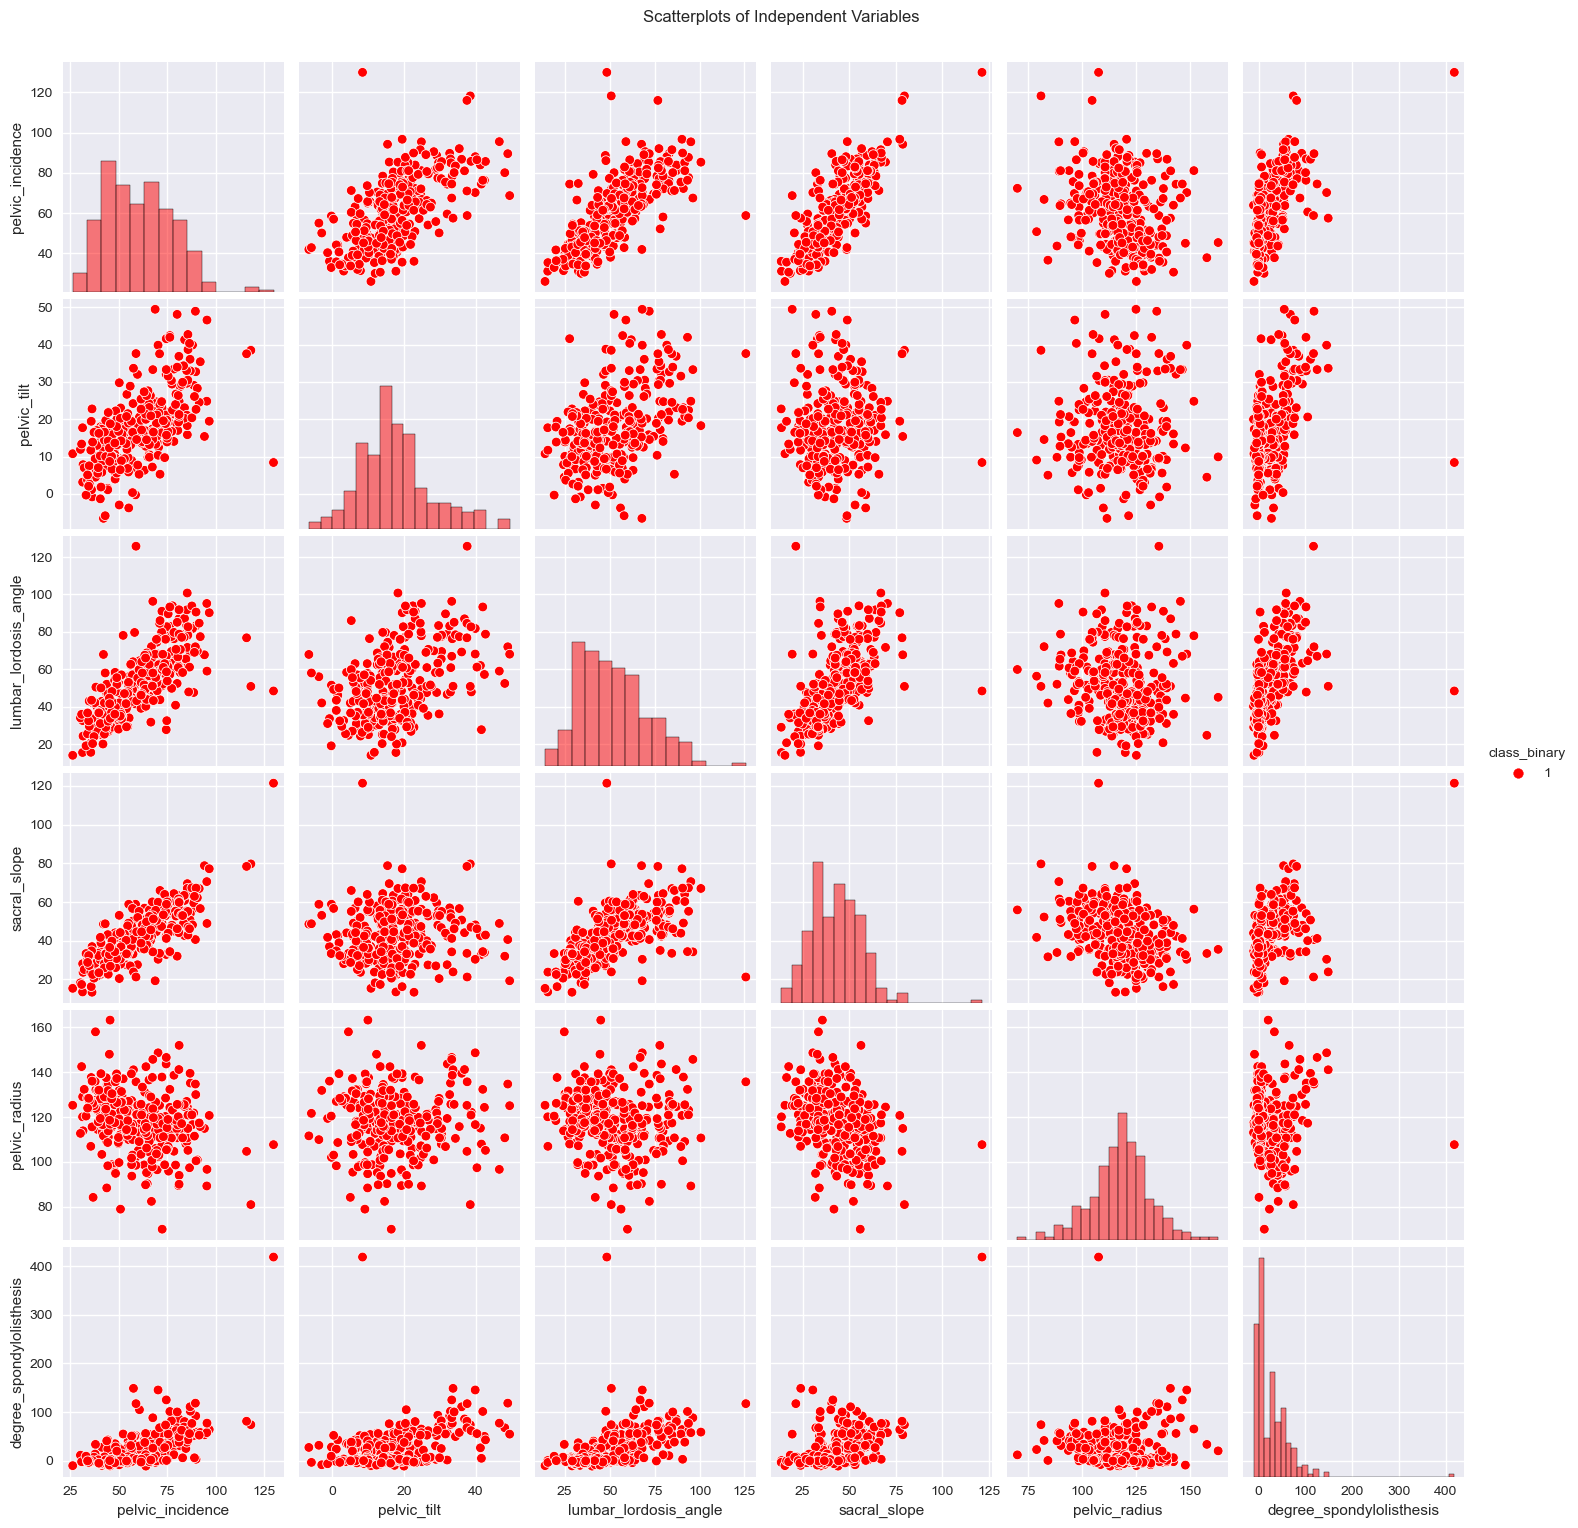

In [ ]:

from scipy.io import arff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# read arff file
def read_arff_file(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.decode('utf-8') 
    return df, meta
arff_data, meta = read_arff_file('column_2C_weka.arff')

df = pd.DataFrame(arff_data)

#features
features = df.columns[:6]
df["class"] = df["class"].str.decode("utf-8")
df["class_binary"] = df["class"].apply(lambda x: 0 if x == "Normal" else 1)

## i. Make scatterplots of the independent variables in the dataset. Use color toshow Classes 0 and 1.
sns.pairplot(df, vars=features, hue="class_binary",
             palette={0: "blue", 1: "red"}, diag_kind="hist")
plt.suptitle("Scatterplots of Independent Variables", y=1.02)
plt.show()

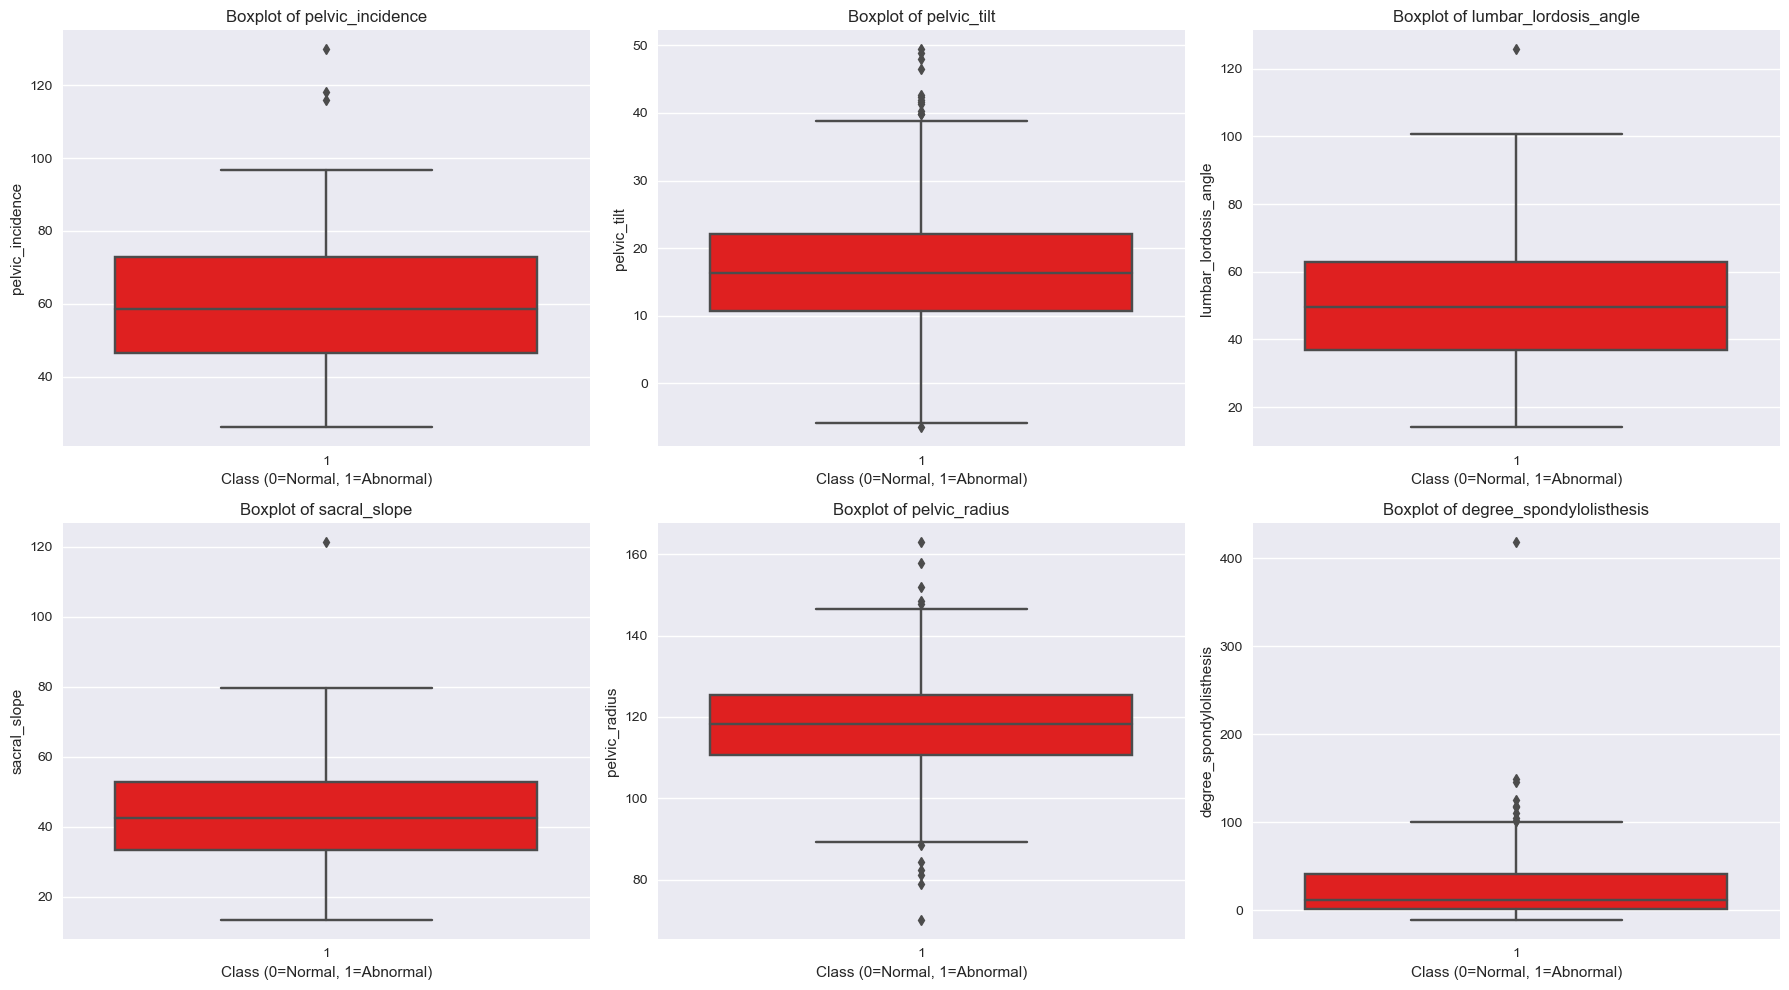

In [78]:
# ii. Boxplots 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flatten(), features):
    sns.boxplot(x="class_binary", y=col, data=df,
                palette={0: "blue", 1: "red"}, ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xlabel("Class (0=Normal, 1=Abnormal)")
plt.tight_layout()
plt.show()

In [79]:
# iii. Train/Test Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as thetraining set and the rest of the data as the test set.
X = arff_data.iloc[:, :-1]
y = arff_data.iloc[:, -1]

class0 = arff_data[arff_data['class'] == "Normal"]
class1 = arff_data[arff_data['class'] == "Abnormal"]

train_class0 = class0.iloc[:70]
train_class1 = class1.iloc[:140]
train_set = pd.concat([train_class0, train_class1])

test_set = pd.concat([class0.iloc[70:], class1.iloc[140:]])

X_train, y_train = train_set.iloc[:, :-1].values, train_set.iloc[:, -1].values
X_test, y_test = test_set.iloc[:, :-1].values, test_set.iloc[:, -1].values

print("train_size:", len(X_train))
print("test_size:", len(X_test))




train_size: 210
test_size: 100


best k value: 3


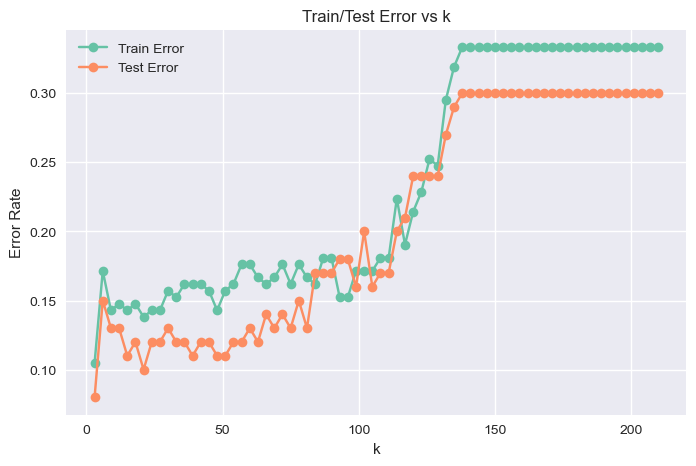

confusion matrix:
 [[23  7]
 [ 1 69]]
TPR (Recall): 0.986
TNR (Specificity): 0.767
Precision: 0.908
F1-score: 0.945


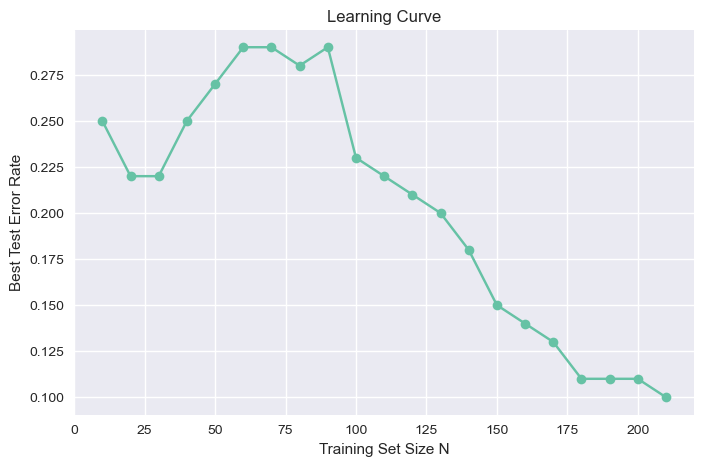

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
k_values = list(range(len(X_train), 0, -3))  # {210, 207, …, 6, 3}
train_errors = []
test_errors = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    clf.fit(X_train, y_train)

    train_error = 1 - clf.score(X_train, y_train)
    test_error = 1 - clf.score(X_test, y_test)

    train_errors.append(train_error)
    test_errors.append(test_error)

# find best k
best_k = k_values[np.argmin(test_errors)]
print("best k value:", best_k)
plt.figure(figsize=(8,5))
plt.plot(k_values, train_errors, label="Train Error", marker='o')
plt.plot(k_values, test_errors, label="Test Error", marker='o')
plt.xlabel("k")
plt.ylabel("Error Rate")
plt.title("Train/Test Error vs k")
plt.legend()
plt.grid(True)
plt.show()

# 4. calculate at the best k
clf = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=["Normal", "Abnormal"])
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)  
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, pos_label="Abnormal")
f1 = f1_score(y_test, y_pred, pos_label="Abnormal")

print("confusion matrix:\n", cm)
print(f"TPR (Recall): {tpr:.3f}")
print(f"TNR (Specificity): {tnr:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1-score: {f1:.3f}")

# 5. Best Test Error vs Training Set Size
train_sizes = range(10, 211, 10)
best_errors = []

for N in train_sizes:
    class0_sub = class0.iloc[:N//3]
    class1_sub = class1.iloc[:N - N//3]
    subset = pd.concat([class0_sub, class1_sub])

    X_sub = subset.iloc[:, :-1].values
    y_sub = subset.iloc[:, -1].values

    best_error = 1.0
    for k in range(1, N, 5):  # {1, 6, 11, …, N-4, N-1}
        if k >= len(X_sub):
            continue
        clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        clf.fit(X_sub, y_sub)
        error = 1 - clf.score(X_test, y_test)
        best_error = min(best_error, error)

    best_errors.append(best_error)

# learning curve
plt.figure(figsize=(8,5))
plt.plot(train_sizes, best_errors, marker='o')
plt.xlabel("Training Set Size N")
plt.ylabel("Best Test Error Rate")
plt.title("Learning Curve")
plt.grid(True)
plt.show()

In [81]:
k_vals = list(range(1,197,5))  # 1,6,11,...,196

def eval_knn(clf, Xtr, ytr, Xte, yte):
    clf.fit(Xtr, ytr)
    te = 1 - accuracy_score(yte, clf.predict(Xte))
    tr = 1 - accuracy_score(ytr, clf.predict(Xtr))
    return te, tr

results = []
# Manhattan (p=1)
best = (1.0, None, None)
for k in k_vals:
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)
    te,tr = eval_knn(clf, X_train, y_train, X_test, y_test)
    if te < best[0]:
        best = (te, k, tr)
results.append({'metric':'Manhattan','best_k':best[1],'test_err':best[0],'train_err':best[2]})
man_k = best[1]

# Minkowski varying p using man_k
best_lp = (1.0, None, None)
for logp in [round(0.1*i,1) for i in range(1,11)]: # 0.1..1.0
    p = 10**logp
    clf = KNeighborsClassifier(n_neighbors=man_k, metric='minkowski', p=p)
    te,tr = eval_knn(clf, X_train, y_train, X_test, y_test)
    if te < best_lp[0]:
        best_lp = (te, logp, tr)
results.append({'metric':'Minkowski_vary_p','best_log10_p':best_lp[1],'test_err':best_lp[0],'train_err':best_lp[2]})

# Chebyshev
best = (1.0,None,None)
for k in k_vals:
    clf = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    te,tr = eval_knn(clf, X_train, y_train, X_test, y_test)
    if te < best[0]:
        best = (te,k,tr)
results.append({'metric':'Chebyshev','best_k':best[1],'test_err':best[0],'train_err':best[2]})

# Mahalanobis: whiten with sqrt(VI)
S = np.cov(X_train, rowvar=False)
VI = np.linalg.pinv(S)
eigvals,eigvecs = np.linalg.eigh(VI)
eigvals[eigvals<0]=0
sqrtVI = eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T
Xtr_w = X_train.dot(sqrtVI.T)
Xte_w = X_test.dot(sqrtVI.T)
best = (1.0,None,None)
for k in k_vals:
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    te,tr = eval_knn(clf, Xtr_w, y_train, Xte_w, y_test)
    if te < best[0]:
        best = (te,k,tr)
results.append({'metric':'Mahalanobis','best_k':best[1],'test_err':best[0],'train_err':best[2]})

# Euclidean baseline
best = (1.0,None,None)
for k in k_vals:
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    te,tr = eval_knn(clf, X_train, y_train, X_test, y_test)
    if te < best[0]:
        best = (te,k,tr)
results.append({'metric':'Euclidean','best_k':best[1],'test_err':best[0],'train_err':best[2]})

print(pd.DataFrame(results))

             metric  best_k  test_err  train_err  best_log10_p
0         Manhattan     1.0      0.11   0.000000           NaN
1  Minkowski_vary_p     NaN      0.11   0.000000           0.7
2         Chebyshev    21.0      0.11   0.133333           NaN
3       Mahalanobis     1.0      0.15   0.000000           NaN
4         Euclidean    21.0      0.10   0.138095           NaN


In [82]:
# (e) weighted voting
weights_res=[]
for desc, kwargs in [('Euclidean', {'metric':'euclidean'}),
                     ('Manhattan', {'metric':'minkowski','p':1}),
                     ('Chebyshev', {'metric':'chebyshev'})]:
    best=(1.0,None,None)
    for k in k_vals:
        if kwargs.get('metric')=='minkowski':
            clf = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='minkowski', p=kwargs['p'])
        else:
            clf = KNeighborsClassifier(n_neighbors=k, weights='distance', metric=kwargs['metric'])
        te,tr = eval_knn(clf, X_train, y_train, X_test, y_test)
        if te < best[0]:
            best=(te,k,tr)
    weights_res.append({'metric':desc + ' (weighted)','best_k':best[1],'test_err':best[0],'train_err':best[2]})
print(pd.DataFrame(weights_res))

                 metric  best_k  test_err  train_err
0  Euclidean (weighted)       6      0.10        0.0
1  Manhattan (weighted)      26      0.10        0.0
2  Chebyshev (weighted)      16      0.11        0.0


# f
The lowest training error rate is 0.0 (0%). This occurred under the Manhattan distance (p=1) and the Mahalanobis distance, both with 𝑘∗=1 This result is expected: when k=1, the 1-NN classifier always finds each sample itself as the nearest neighbor in the training set, so the training error becomes zero. However, this does not indicate good generalization — under the same configuration, the test error remains around 11–15%, showing that k=1 clearly leads to overfitting.